In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from utils import detrend, reg_slope, monthly_anomalies, standardize

In [2]:
def emi_ashok2007(sst_anomaly: xr.DataArray):
    a_region = dict(lon=slice(165, 220), lat=slice(-10, 10))
    b_region = dict(lon=slice(250, 290), lat=slice(-15, 5))
    c_region = dict(lon=slice(125, 145), lat=slice(-10, 20))

    aindex = sst_mon_anom.sel(**a_region).mean(('lon', 'lat'))
    bindex = sst_mon_anom.sel(**b_region).mean(('lon', 'lat'))
    cindex = sst_mon_anom.sel(**c_region).mean(('lon', 'lat'))
    emi = (aindex - 0.5 * bindex - 0.5 * cindex)

    return emi

In [3]:
def n_wp_cp(nino3, nino4):
    alpha = np.where(nino3 * nino4 > 0, 0.4, 0.)
    ict = nino3 - alpha * nino4
    iwp = (nino4 - alpha * nino3)
    return iwp

### 1. Based on NEMO data

In [4]:
t_grid_file = xr.open_zarr("data/ORCA025.L46-KFS006_TroPA.zarr")

In [5]:
eq = dict(lat=0)
nino3_region = dict(lon=slice(210, 270), lat=slice(-5, 5))
nino4_region = dict(lon=slice(160, 210), lat=slice(-5, 5))

#### 1.1 SSH 

In [6]:
ssh_eq = detrend(
    monthly_anomalies(
        t_grid_file.sossheig.sel(**eq)
    ).compute()
)

#### 1.2 D20 

In [7]:
d20_mon = monthly_anomalies(
        -1 * t_grid_file.d20.sel(**eq)
).compute()
d20_eq = detrend(d20_mon.where(
        (~d20_mon.isnull()).all("time"),
        0.
    )
).where(
    (~d20_mon.isnull()).all("time")
)
d20_eq.attrs.update({"long_name": "D20 anomaly", "units": "m"})

#### 1.3 NLTI

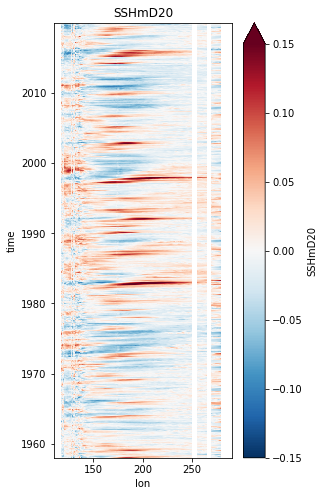

In [8]:
slope = reg_slope(d20_eq, ssh_eq, dim="time")

sshmd20 = (
    ssh_eq - slope * d20_eq
).rename("SSHmD20")

# NLTI should not detrend before getting average of Nino4 region?
# sshmd20=detrend(
#     sshmd20
# )

plt.figure(figsize=(4, 8))
sshmd20.T.plot(vmin=-0.15,vmax=0.15,cmap=plt.cm.RdBu_r)
plt.title("SSHmD20");

In [9]:
nlti_n4eq = sshmd20.sel(lon=nino4_region["lon"]).mean('lon').rename('nlti_n4eq').compute()

#### 1.4 Nino4 SST (only equator) 

In [10]:
sst_mon_anom = monthly_anomalies(t_grid_file.sosstsst)
n3 = sst_mon_anom.sel(**nino3_region).mean(('lon', 'lat')).rename('sst_n3').compute()
n4 = sst_mon_anom.sel(**nino4_region).mean(('lon', 'lat')).rename('sst_n4').compute()
n4eq = sst_mon_anom.sel(**nino4_region).interp(lat=0.).mean('lon').rename('sst_n4').compute()

#### 1.5 From Ashok2007 EMI

In [11]:
emi = emi_ashok2007(sst_mon_anom).rename("emi").compute()

#### 1.6 From Ren and Jin(2010)  Nwp:CP 

In [12]:
iwp = n_wp_cp(n3, n4).rename("iwp").compute()

#### 1.7 sum 

In [13]:
ds_model = xr.Dataset(
    {
        "nlti": nlti_n4eq,
        "n4": n4eq,
        "emi": emi,
        "iwp": iwp
    }
)  

### 2. Based on Hadley data 
#### 2.1 Nino4 SST (only equator)

In [14]:
ssth_o = xr.open_dataset('data/HadISST_sst.nc').sst[:,::-1,:].rename(
   {   
       'latitude':'lat',
       'longitude':'lon', 
   }
).sel(time=slice("1958-01-16", "2019-12-17"))

In [15]:
ssth_all = ssth_o.assign_coords(
    {'lon': (ssth_o.lon+ 360) % 360.}
).reindex(lon= np.arange(360)+0.5)

In [16]:
ssth_a = monthly_anomalies(ssth_all)

In [17]:
h_n3 = ssth_a.sel(**nino3_region).mean(('lon', 'lat')).rename('h_n3').compute()
h_n4 = ssth_a.sel(**nino4_region).mean(('lon', 'lat')).rename('h_n4').compute()

In [18]:
h_n4eq = ssth_a.interp(lat=0.).sel(lon=slice(160, 210)).mean('lon').rename('h_n4eq').compute()

#### 2.2 From Ashok2007 EMI: CP 

In [19]:
h_emi = emi_ashok2007(ssth_a).compute()

#### 2.3 From Ren and Jin(2010) ict:EP / iwp:CP 

In [20]:
h_iwp = n_wp_cp(h_n3, h_n4)

#### 2.4 sum 

In [21]:
h_ds = xr.Dataset({"h_n4": h_n4eq, "h_emi": h_emi, "h_iwp":h_iwp}) 

### 3. 21y-Running-variance

In [22]:
ds = ds_model.merge(h_ds)

In [24]:
ds_var = detrend(
    ds.rolling(time=21*12, center=True).construct("window_dim").dropna("time"),
    dim="window_dim"
).var("window_dim", ddof=1).compute()

ds_var = ds_var.rename(
    {
        k: f"{k}_var"
        for k in list(ds_var.variables.keys()) if k not in ("time", "lat")
    }
)

## Write output

In [25]:
!rm -rf data_fig3.zarr
ds_var.to_zarr('data_fig3.zarr/');